In [1]:
import tensorflow as tf
# TensorFlow GPU 메모리 할당 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 첫 번째 GPU에 대해 메모리 1GB만 할당
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # GPU 초기화 전에 가상 장치를 설정해야 함
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
import gc
import time
import cv2
import seaborn as sns
sns.set()
import plotly
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, Input, models
import time

from IPython import display

In [3]:
df=pd.read_pickle("df_26.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30078 entries, 150 to 679279
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        30078 non-null  object 
 1   dieSize         30078 non-null  float64
 2   lotName         30078 non-null  object 
 3   waferIndex      30078 non-null  float64
 4   trianTestLabel  30078 non-null  object 
 5   failureType     30078 non-null  object 
 6   waferMapDim_x   30078 non-null  int64  
 7   waferMapDim_y   30078 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB


In [4]:
# To generate GIFs
!pip install -q imageio

In [5]:
sw = np.ones((1, 26, 26))
label = list()
for i in range(len(df)):
    # skip null label
    if len(df.iloc[i,:]['failureType']) == 2:
        continue
    sw = np.concatenate((sw, df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(df.iloc[i,:]['failureType'])

In [6]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [7]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [8]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [9]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [10]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


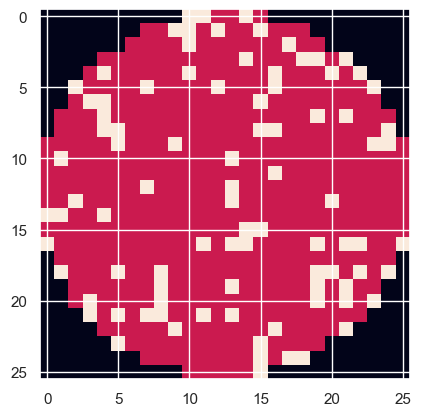

Faulty case : ['none'] 


In [11]:
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [12]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [13]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [14]:
len(x)

14366

In [15]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

C:\Users\USER\AppData\Local\Temp\ipykernel_4316\1672712627.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_x[w, i, j, int(x[w, i, j])] = 1


In [16]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [17]:
# parameter
epoch=15
batch_size=256

In [18]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [19]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [20]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
57/57 - 11s - loss: 0.1007 - 11s/epoch - 194ms/step
Epoch 2/15
57/57 - 3s - loss: 0.0553 - 3s/epoch - 57ms/step
Epoch 3/15
57/57 - 3s - loss: 0.0373 - 3s/epoch - 58ms/step
Epoch 4/15
57/57 - 3s - loss: 0.0248 - 3s/epoch - 58ms/step
Epoch 5/15
57/57 - 3s - loss: 0.0181 - 3s/epoch - 58ms/step
Epoch 6/15
57/57 - 3s - loss: 0.0141 - 3s/epoch - 57ms/step
Epoch 7/15
57/57 - 3s - loss: 0.0114 - 3s/epoch - 57ms/step
Epoch 8/15
57/57 - 3s - loss: 0.0095 - 3s/epoch - 55ms/step
Epoch 9/15
57/57 - 3s - loss: 0.0080 - 3s/epoch - 54ms/step
Epoch 10/15
57/57 - 3s - loss: 0.0069 - 3s/epoch - 57ms/step
Epoch 11/15
57/57 - 3s - loss: 0.0060 - 3s/epoch - 57ms/step
Epoch 12/15
57/57 - 3s - loss: 0.0052 - 3s/epoch - 57ms/step
Epoch 13/15
57/57 - 3s - loss: 0.0047 - 3s/epoch - 56ms/step
Epoch 14/15
57/57 - 3s - loss: 0.0042 - 3s/epoch - 55ms/step
Epoch 15/15
57/57 - 3s - loss: 0.0038 - 3s/epoch - 58ms/step


In [21]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [22]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [23]:
with tf.device('/cpu:0'):
# Encode original faulty wafer
    encoded_x = encoder.predict(new_x)

449/449 [==============================] - 3s 6ms/step


In [24]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

In [25]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

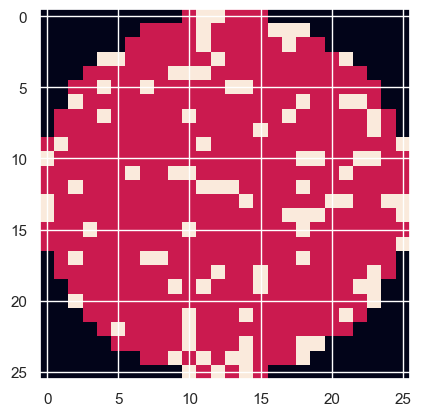

In [26]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 [==============================] - 5s 12ms/step


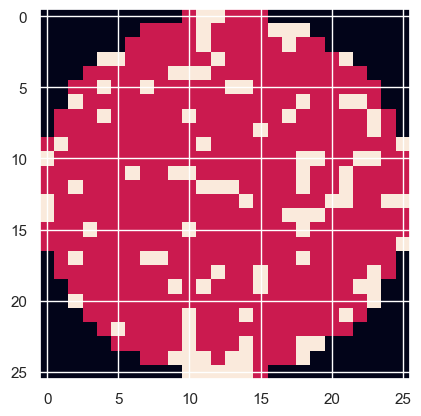

In [27]:
with tf.device('/cpu:0'):
# check new noised faulty wafer data
    noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
    plt.imshow(noised_gen_x[3])

449/449 [==============================] - 7s 15ms/step


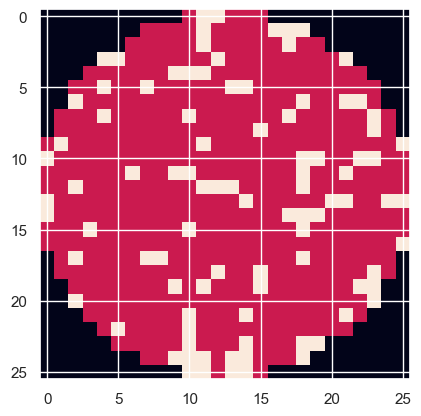

In [28]:
with tf.device('/cpu:0'):
# check reconstructed original faulty wafer data
    gen_x = np.argmax(ae.predict(new_x), axis=3)
    plt.imshow(gen_x[3])

In [29]:
with tf.device('/cpu:0'):
    # Function to generate augmented data
    # augment function define
    def gen_data(wafer, label):
    # Encode input wafer
        encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
        gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 4000
        for i in range((4000//len(wafer)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
        gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
        return gen_x[1:], gen_y[1:]


In [30]:

with tf.device('/cpu:0'):# Augmentation for all faulty case.
    for f in faulty_case : 
        # skip none case
        if f == 'none' : 
            continue
    
        gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
        new_x = np.concatenate((new_x, gen_x), axis=0)
        y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 9ms/step


In [31]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (46867, 26, 26, 3), new_y shape : (46867, 1)


In [32]:
new_x_fs1=new_x.copy()
y_fs1=y.copy()

In [65]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y_fs1[y_fs1==f])))

Center : 4140
Donut : 4002
Edge-Loc : 4440
Edge-Ring : 4061
Loc : 4455
Near-full : 4032
Random : 4144
Scratch : 4104
none : 13489


In [66]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=13489, replace=False)]
# delete choiced index data.
new_x_fs = np.delete(new_x_fs1, none_idx, axis=0)
new_y_fs = np.delete(y_fs1, none_idx, axis=0)
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x_fs.shape, new_y_fs.shape))

After Delete "none" class new_x shape : (33378, 26, 26, 3), new_y shape : (33378, 1)


In [67]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y_fs[new_y_fs==f])))

Center : 4140
Donut : 4002
Edge-Loc : 4440
Edge-Ring : 4061
Loc : 4455
Near-full : 4032
Random : 4144
Scratch : 4104
none : 0


In [68]:
new_x_copy=new_x_fs.copy()
new_y_copy=new_y_fs.copy()

In [69]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y_copy[new_y_copy==l] = i
    
# one-hot-encoding
new_y_copy = to_categorical(new_y_copy)

In [70]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x_copy, new_y_copy,
                                                    test_size=0.33,
                                                    random_state=2019)

In [71]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (22363, 26, 26, 3), y : (22363, 8)
Test x: (11015, 26, 26, 3), y : (11015, 8)


In [93]:
print(new_x_copy.shape)
print(new_y_fs.shape)
print(new_y_copy.shape)
np.save('af_ende_x.npy', new_x_copy)
np.save('af_ede_y.npy', new_y_fs)


(33378, 26, 26, 3)
(33378, 1)
(33378, 8)


In [90]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [91]:
with tf.device('/cpu:0'):
# Make keras model to sklearn classifier.
    model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
    kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
    results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
    print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

C:\Users\USER\AppData\Local\Temp\ipykernel_4316\359353576.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2)


Epoch 1/10
15/15 - 67s - loss: 1.6835 - accuracy: 0.5131 - 67s/epoch - 4s/step
Epoch 2/10
15/15 - 70s - loss: 0.3995 - accuracy: 0.8496 - 70s/epoch - 5s/step
Epoch 3/10
15/15 - 71s - loss: 0.1201 - accuracy: 0.9678 - 71s/epoch - 5s/step
Epoch 4/10
15/15 - 72s - loss: 0.0377 - accuracy: 0.9905 - 72s/epoch - 5s/step
Epoch 5/10
15/15 - 74s - loss: 0.0157 - accuracy: 0.9975 - 74s/epoch - 5s/step
Epoch 6/10
15/15 - 74s - loss: 0.0111 - accuracy: 0.9972 - 74s/epoch - 5s/step
Epoch 7/10
15/15 - 70s - loss: 0.0092 - accuracy: 0.9981 - 70s/epoch - 5s/step
Epoch 8/10
15/15 - 69s - loss: 0.0076 - accuracy: 0.9976 - 69s/epoch - 5s/step
Epoch 9/10
15/15 - 71s - loss: 0.0082 - accuracy: 0.9977 - 71s/epoch - 5s/step
Epoch 10/10
15/15 - 70s - loss: 0.0084 - accuracy: 0.9977 - 70s/epoch - 5s/step
8/8 - 10s - loss: 0.0063 - accuracy: 0.9987 - 10s/epoch - 1s/step
Epoch 1/10
15/15 - 72s - loss: 1.2134 - accuracy: 0.5466 - 72s/epoch - 5s/step
Epoch 2/10
15/15 - 70s - loss: 0.3162 - accuracy: 0.8962 - 70s/e